# Processing

### Initialization

In [8]:
import numpy as np
sample = np.load('data\samplevideo.npy')
print(sample[0,:])

[ 134.  141.  128. ...,   81.   57.   74.]


In [9]:
def show_frame(frame):
    
    image = mp.imshow(frame.reshape((120,160)),cmap='Greys_r')

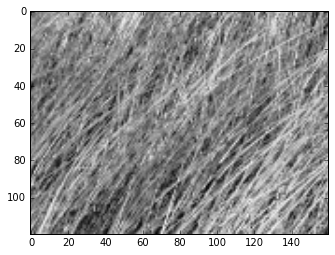

In [10]:
# Plot the first frame
import matplotlib.pyplot as mp
% matplotlib inline
show_frame(sample[0,:])

In [11]:
# Initialize the latent variable using PCA:
from sklearn.decomposition import PCA

N = sample.shape[0] # count of samples
D = sample.shape[1] # dimensionality of observed space
Q = 20 # dimensionality of observed space

X = np.zeros((N,Q)) # Initialize the latent variable

#normilizing data:
sample_mean = np.mean(sample, 0)
sample_std = np.std(sample, 0)

sample = (sample - sample_mean)/sample_std # normalization
pca = PCA(n_components=Q) 
X = pca.fit_transform(sample) # performing PCA
print(X[0,:])

[ 23.73651164 -20.94734111  23.281226    22.6802055   -7.50919708
  34.30870091 -12.46201579   8.07417771 -12.95784813   9.80002935
  -6.88500422   0.63095893 -13.29798142  19.54781085  -4.42927045
   2.70507576  -5.53067023   4.97089492  -7.19820107  13.64289273]


## Kernels

<font color='red'>**Necessary kerns:**</font> 'lin','rbf','poly','ratquad','mlp','matern32'. Let's try to use GPy (Gaussian Process framework in python, from the Sheffield machine learning group). We'll get the following:

'lin' **class Linear**(input_dim, variances=None, ARD=False, active_dims=None, name='linear')

'rbf' **class RBF**(input_dim, variance=1.0, lengthscale=None, ARD=False, active_dims=None, name='rbf', useGPU=False, inv_l=False)

'poly' **class Poly**(input_dim, variance=1.0, scale=1.0, bias=1.0, order=3.0, active_dims=None, name='poly')

'ratquad' **class RatQuad**(input_dim, variance=1.0, lengthscale=None, power=2.0, ARD=False, active_dims=None, name='RatQuad')

'mlp' **class MLP**(input_dim, variance=1.0, weight_variance=1.0, bias_variance=1.0, ARD=False, active_dims=None, name='mlp')

'matern32' **class Matern32**(input_dim, variance=1.0, lengthscale=None, ARD=False, active_dims=None, name='Mat32')

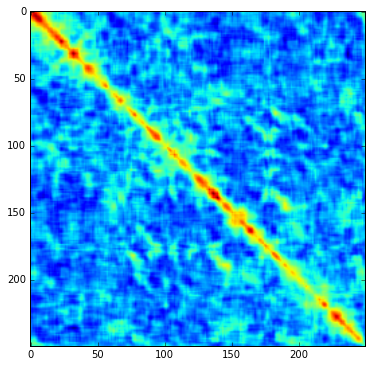

In [12]:
import GPy

fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.Linear(Q).K(X,X))

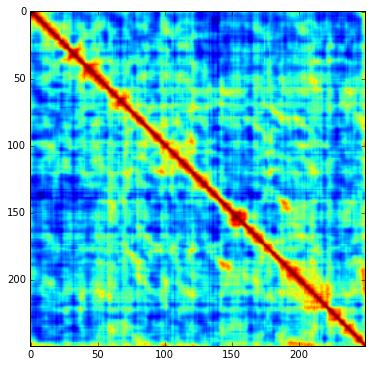

In [13]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.RBF(Q,1,100).K(X,X))

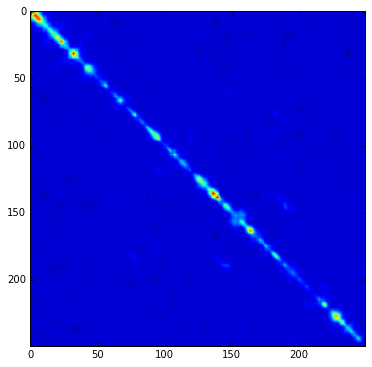

In [14]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.Poly(Q,1,100).K(X,X))

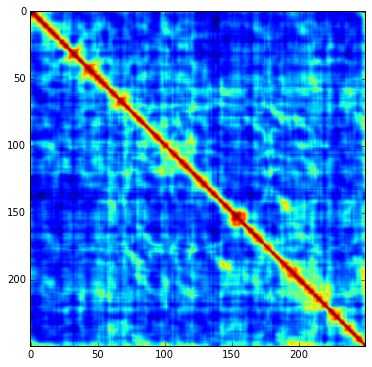

In [15]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.RatQuad(Q,1,100).K(X,X))

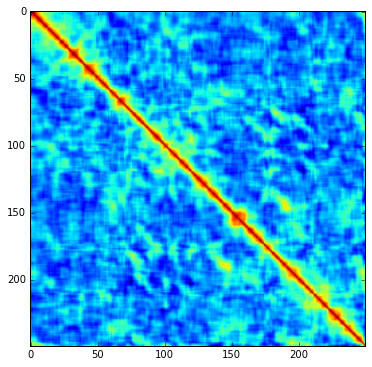

In [16]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.MLP(Q,1,100).K(X,X))

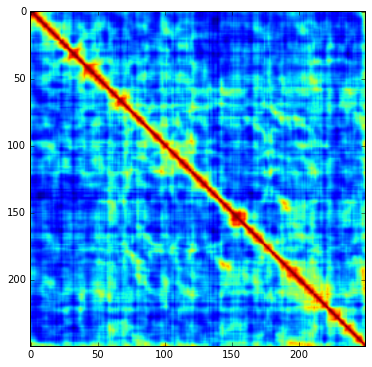

In [17]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.Matern52(Q,1,100).K(X,X))

### Optimization

Kronecker Delta function:

In [18]:
def kd(x1,x2):
    
    if np.any(x1 == x2):
        return 1
    else:
        return 0

In [19]:
def kd2(N,x):
    
    result = np.zeros((N,N))
    
    for i in range(N):
        for j in range(N):
            result[i,j] = kd(x[i,:],x[j,:])
    
    return result

Kernel matrices:

In [20]:
def K_x(N,Q,w,x1,x2):
    
    k1 = GPy.kern.Linear(Q).K(x1[0:N-1,:],x2[0:N-1,:])
    k2 = GPy.kern.RBF(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    k3 = GPy.kern.Poly(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    k4 = GPy.kern.RatQuad(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    k5 = GPy.kern.MLP(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    k6 = GPy.kern.Matern52(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    
    #return w[0]*k1 + w[1]*k2 + w[2]*k3 + w[3]*k4 + w[4]*k5 + w[5]*k6 + w[6]*kd(x1[0:N-1,:],x2[0:N-1,:])
    return w[0]*k1 + w[1]*k2 + w[3]*k4 + w[4]*k5 + w[5]*k6 + w[6]*kd2(N-1,x1)# + w[2]*k3 

In [21]:
def K_x_kern(Q):
    
    k1 = GPy.kern.Linear(Q)
    k2 = GPy.kern.RBF(Q,1,100)
    k3 = GPy.kern.Poly(Q,1,100)
    k4 = GPy.kern.RatQuad(Q,1,100)
    k5 = GPy.kern.MLP(Q,1,100)
    k6 = GPy.kern.Matern52(Q,1,100)
    
    #return w[0]*k1 + w[1]*k2 + w[2]*k3 + w[3]*k4 + w[4]*k5 + w[5]*k6 + w[6]*kd(x1[0:N-1,:],x2[0:N-1,:])
    return k1 + k2 + k4 + k5 + k6# + kd2(N-1,x1)# + w[2]*k3 

In [22]:
def K_y(theta,x1,x2):
    
    return theta[0]*np.exp(-0.5*theta[1]*((x1 - x2)**2).sum(axis=-1)) + theta[2]*kd(x1,x2)

In [23]:
def K_y_kern(Q):
    
    return GPy.kern.RBF(Q,1,100)# + theta[2]*kd(x1,x2)

Functions to optimize:

In [24]:
def f1_likelihood(N,D,Q,Kx,Ky,X,Y,theta,lamb):
    
    C = 0
    Kx_inv = np.linalg.inv(Kx)
    Ky_inv = np.linalg.inv(Ky)
    part1 = 0.5*D*np.log(np.linalg.det(Ky))
    part2 = 0.5*np.trace(np.matmul(Ky_inv,np.matmul(Y,np.linalg.pinv(Y))))
    part3 = 0.5*Q*np.log(np.linalg.det(Kx))
    part4 = 0.5*np.trace(np.matmul(Kx_inv,np.matmul(X[1:N],np.transpose(X[1:N]))))
    part5 = np.sum(theta)
    part6 = np.sum(lamb)
    
    return part1 + part2 + part3 + part4 + part5 + part6 + C

In [25]:
def f2_likelihood(N,Q,Kx,X,W):
    
    alpha = 1
    Kx_inv = np.linalg.inv(Kx)
    part1 = 0.5*Q*np.log(np.linalg.det(Kx_inv))
    part2 = 0.5*np.trace(Kx_inv*np.matmul(X[1:N],np.transpose(X[1:N])))
    part3 = alpha*np.linalg.norm(W,2)

    return part1 + part2 + part3

Kx kernel matrix test:

[[ 4707.46577625  5300.51240898  5432.67350878 ...,  1263.3018179
   1721.7195948   1707.08131007]
 [ 5300.51240898  6421.41032769  6751.19375397 ...,  1364.89793108
   1876.76047981  1914.4848525 ]
 [ 5432.67350878  6751.19375397  7373.51659116 ...,  1471.90906741
   2006.54533349  2088.61590912]
 ..., 
 [ 1263.3018179   1364.89793108  1471.90906741 ...,  4019.46086512
   2854.78261545  1325.66019282]
 [ 1721.7195948   1876.76047981  2006.54533349 ...,  2854.78261545
   2752.86384763  1803.35767487]
 [ 1707.08131007  1914.4848525   2088.61590912 ...,  1325.66019282
   1803.35767487  1935.77273337]]
1.51468158772e-12
-27.2158158722


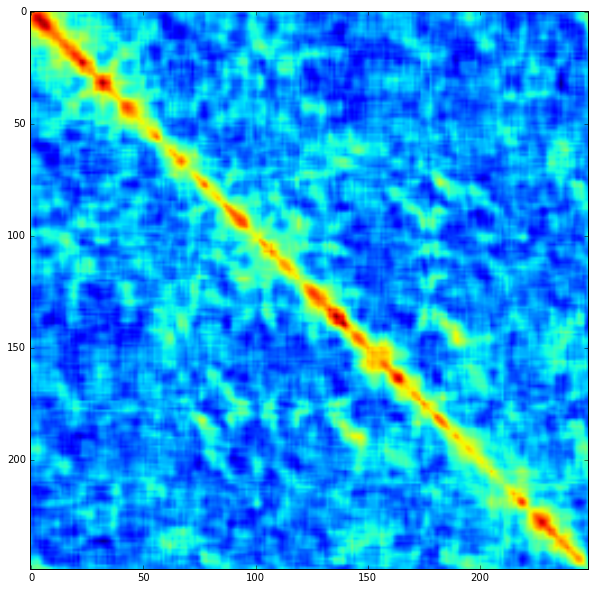

In [26]:
weights = [1, 1, 0, 1, 1, 1, 0]
Kx = K_x(N,Q,weights,X,X)

print(Kx)
print(np.linalg.det(Kx))
print(np.log(np.linalg.det(Kx)))

fig = mp.figure(figsize=(10,10)) # scale of the plot
image = mp.imshow(Kx)

Ky kernel matrix test:

[[-1.         -0.02601924 -0.05892317 ..., -0.18184414 -0.14898907
  -0.17448359]
 [-0.02601924 -1.         -0.01450185 ..., -0.23728731 -0.20249408
  -0.23182361]
 [-0.05892317 -0.01450185 -1.         ..., -0.26323916 -0.22620688
  -0.26295111]
 ..., 
 [-0.18184414 -0.23728731 -0.26323916 ..., -1.         -0.05259622
  -0.11448249]
 [-0.14898907 -0.20249408 -0.22620688 ..., -0.05259622 -1.         -0.02785521]
 [-0.17448359 -0.23182361 -0.26295111 ..., -0.11448249 -0.02785521 -1.        ]]
11.208578066


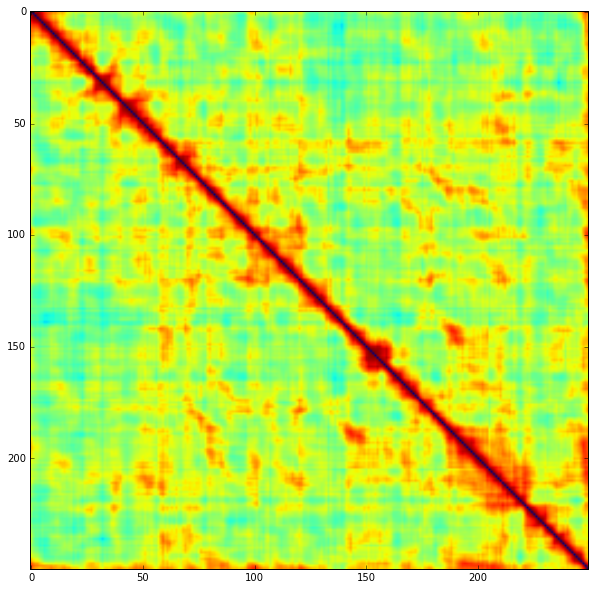

In [27]:
theta = [1, 0.0001, -1]
Ky = K_y(theta,X.reshape(1,-1,Q),X.reshape(-1,1,Q))
Ky = Ky + theta[2]*kd2(N,X)

print(Ky)
print(np.log(np.linalg.det(Ky)))

fig = mp.figure(figsize=(10,10)) # scale of the plot
image = mp.imshow(Ky)

f1_likelihood test:

In [28]:
np.matmul(np.transpose(sample),np.matmul(np.linalg.inv(Ky),sample)).sum()

54108775.187295668

In [29]:
np.trace(np.matmul(np.linalg.inv(Ky),np.matmul(sample,np.linalg.pinv(sample))))

-244.02514369328119

In [30]:
lamb = [1, 1, 1, 1, 1, 1]

print(f1_likelihood(N,D,Q,Kx,Ky,X,sample,theta,lamb))

239620.752095


f2_likelihood test:

In [31]:
#a = [[1,0,0],[0,1,0],[0,0,1]]
#x = [9,8,7,6]
#c = [1,2,3,4,5,6]
#print(f2_likelihood(20,4,a,x,c))

print(f2_likelihood(N,Q,Kx,X,weights))

2748362.16638


Gradients of functions f1 and f2:

In [32]:
def f1_gradient(N,D,Q,Kx,Ky,X,Y,theta,lamb):
    
    Kx_inv = np.linalg.inv(Kx)    
    Ky_inv = np.linalg.inv(Ky)
    
    dL_dKy = 0.5*D*np.transpose(Ky_inv)-0.5*np.transpose(np.matmul((Ky_inv*np.matmul(Y,np.transpose(Y))),Ky_inv))
    dL_dKx = 0.5*Q*np.transpose(Kx_inv)-0.5*np.transpose(np.matmul((Kx_inv*np.matmul(X[1:N],np.transpose(X[1:N]))),Kx_inv))
    dL_dx2 = 0.5*(np.matmul(Kx_inv,X[1:N])+np.matmul(np.transpose(Kx_inv),X[1:N]))
    
    dKy_dX = K_y_kern(Q).gradients_X(np.ones((N-1,N-1)), X[0:N-1,:])
    dKx_dX = K_x_kern(Q).gradients_X(np.ones((N-1,N-1)), X[0:N-1,:])
    dx2_dX = np.ones((Q,Q)) # OK-?
    
    dL_dX = np.matmul(dL_dKy[0:N-1,0:N-1],dKy_dX) 
    dL_dX = dL_dX + np.matmul(dL_dKx,dKx_dX)
    dL_dX = dL_dX + np.matmul(dL_dx2,dx2_dX)
    
    """dL_dTht1 = 0.5*D*np.trace(Ky_inv*dKy_dTht)
    dL_dTht2 = 0.5*np.transpose(np.matmul((Ky_inv*np.matmul(Y,np.transpose(Y))),Ky_inv))*dKy_dTht
    dL_dTht3 = 1/theta
    #dKy_dTht = ?
    
    dL_dTht = dL_dTht1 - dL_dTht2 + dL_dTht3
    
    dL_dLam1 = 0.5*Q*np.trace(Kx_inv*dKx_dLam)
    dL_dLam2 = 0.5*np.transpose(np.matmul((Kx_inv*np.matmul(X[1:N],np.transpose(X[1:N]))),Kx_inv))*dKx_dTLam
    dL_dLam3 = 1/lamb
    #dKx_dLam = ?
    
    dL_dLam = dL_dLam1 - dL_dLam2 + dL_dLam3"""
    
    return dL_dX #[dL_dX, dL_dTheta, dL_dLam]

In [33]:
K_y_kern(Q).gradients_X(np.ones((N-1,N-1)), X[0:N-1,:])

array([[-0.67994177,  0.59832353, -0.67566439, ..., -0.14784931,
         0.21500271, -0.40157602],
       [-0.71769786,  0.68727221, -0.81494125, ..., -0.14514602,
         0.10720609, -0.18566793],
       [-0.65677475,  0.70564511, -0.75901655, ..., -0.17974359,
         0.08749211, -0.06441056],
       ..., 
       [ 0.61365761,  0.35750165, -0.59205894, ..., -0.25013007,
         0.03889527, -0.18467428],
       [ 0.22026099,  0.69624545, -0.51550006, ..., -0.39030579,
        -0.1145838 , -0.4204494 ],
       [-0.17503944,  0.64534258, -0.43249316, ..., -0.14585372,
        -0.29638445, -0.24108338]])

In [34]:
K_x_kern(Q).gradients_X(np.ones((N-1,N-1)), X[0:N-1,:])

array([[-25.47751761,  20.70432244, -23.09198297, ..., -12.00818343,
        -27.10608458,  -7.49672799],
       [-25.51153905,  20.90218783, -23.4342417 , ..., -11.98389366,
        -27.44723775,  -6.82329593],
       [-25.29672868,  20.91825512, -23.22536935, ..., -12.07898663,
        -27.50906798,  -6.45899455],
       ..., 
       [-21.78839269,  20.05612561, -22.90497689, ..., -12.29170188,
        -27.61231757,  -6.83833318],
       [-22.9547885 ,  21.13464662, -22.71157398, ..., -12.78369682,
        -28.10428912,  -7.58181747],
       [-24.17376083,  21.01969338, -22.4910994 , ..., -12.02663597,
        -28.70329719,  -7.02166064]])

In [35]:
def f2_gradient2(N,Q,Kx,X,W):
    
    #params = mk_weightsConstrain(params)
    
    #[Xin, Xout] = mk_priorIO(X, segments)
    
    Kx_inv = np.linalg.inv(Kx)
    #dL_dKx = -Q/2*invKx + 0.5*invKx*(Xout*Xout')*invKx
    
    #g = zeros(length(kern.comp),1)
    
    #for i = 1:length(kern.comp)
    #    g(i) = sum(sum(dL_dKx .* Kx{i}))
    
    norm2 = 1/np.linalg.norm(W,2)
    
    #for i = 1:length(kern.comp)
    #    g(i) = g(i) + norm2 * params(i)
    
    g = g/np.linalg.norm(g)
    
    return -np.transpose(g)

In [49]:
def f2_gradient(N,Q,Kx,X,W):
    
    Kx_inv = np.linalg.inv(Kx)    
    
    dF_dKx = 0.5*Q*np.transpose(Kx_inv)-0.5*np.transpose(np.matmul((Kx_inv*np.matmul(X[1:N],np.transpose(X[1:N]))),Kx_inv))
    
    dF_dW = np.sum(dF_dKx) * np.sum(Kx) + W/np.linalg.norm(W,2)
    
    return dF_dW

f1_gradient test:

In [37]:
gradf1 = f1_gradient(N,D,Q,Kx,Ky,X,sample,theta,lamb)
print(gradf1)
print(np.size(gradf1))

[[ 101554.10082846  -74900.96896601   77350.14432853 ...,   54813.77736883
    98194.81325044   25455.97499825]
 [ -75308.43970041   58283.2620586   -52706.93639633 ...,  -62362.43043388
   -68523.92989562  -22663.55774367]
 [  21896.16782632   -9710.81378723    3136.27411149 ...,   44470.26272708
    -8577.49389244   -5460.62322089]
 ..., 
 [ -19082.04818635   18862.12135671  -27390.10566619 ...,  -20401.48356008
   -28209.0012875   -14475.75413072]
 [ -22406.99370748   24635.80880888  -28263.08612035 ...,  -21006.90579109
   -32777.09463194  -19122.27231493]
 [ -45003.29965526   44869.02981112  -43367.77680717 ...,  -29977.59752049
   -58483.71820768  -24512.20895078]]
4980


f2_gradient test:

In [51]:
W = [1,1,1,1,1,1]
gradf2 = f2_gradient(N,Q,Kx,X,W)
print(gradf2)
print(np.size(gradf2))

[  5.31208391e+08   5.31208391e+08   5.31208391e+08   5.31208391e+08
   5.31208391e+08   5.31208391e+08]
6


In [52]:
# TODO: 

#[params, options, flog] = scg('mk_likelihood', params, options, 'mk_gradient', Y, segments, kern)